In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
!pip install whittaker_eilers

from whittaker_eilers import WhittakerSmoother

!pip install roifile

!unzip RoiSet.zip


In [ ]:
################ FUNCTION TO PLOT
def plot_image_overlays(image, overlays, roi_names, **kwargs):  # Added roi_names argument
    """Plot image and overlays (bytes) using matplotlib."""
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='plasma')
    if not isinstance(overlays, list):
        overlays = [overlays]

    # Assuming roi_names is a list with the same length as overlays
    for i, overlay in enumerate(overlays):
        roi = overlay
        roi.plot(ax, color='gray', **kwargs)

        # Get ROI center coordinates for text placement
        # Calculate the centroid manually using the coordinates:
        coordinates = roi.coordinates()  # Get coordinates of the ROI
        x_center = np.mean(coordinates[:, 0])  # Calculate mean of x-coordinates
        y_center = np.mean(coordinates[:, 1])  # Calculate mean of y-coordinates

        # Display ROI name as text
        ax.text(x_center, y_center, roi_names[i], color='white')

        ax.axis('off')
    plt.show()

In [ ]:
from logging import error
# To apply an ROI mask to your calcium imaging analysis:

# Create a binary mask that marks your regions of interest
# Modify to only process pixels within this mask

#### rois coordinates stored in rois_coordinates

########### OPTMISED + ROI
def DFOF_optimized_roi(image_stack, dict_rois_name_xy ):
    total_frame, total_pixel = image_stack.shape[0:2]
    frame_rate = 50
    smooth_frame = 12 * frame_rate // 2  # smooth over 2 seconds

    dict_rois_df_f = dict()

    dict_rois_baseline = dict()

    dict_rois_df = dict()

########## loop over every ROI
    for roi_name, roi_coordinates in dict_rois_name_xy.items():
      #run the function per key and store result in new dictionary
      print(roi_name)

      ########### make the ROI a disk mask ###################

      # Compute the center of the circle
      center_x = np.mean(roi_coordinates[:, 0])
      center_y = np.mean(roi_coordinates[:, 1])

      # Compute the radius as the maximum distance from the center to the boundary points
      radius = int(np.max(np.linalg.norm(roi_coordinates - [center_x, center_y], axis=1)))
      # Create a coordinate grid for the entire image
      y_indices, x_indices = np.meshgrid(np.arange(total_pixel), np.arange(total_pixel), indexing="ij")

      # Compute the distance from each pixel to the circle center
      distance_from_center = np.sqrt((x_indices - center_x) ** 2 + (y_indices - center_y) ** 2)

      # Create the binary mask (True for pixels inside the circle, False outside)
      roi_mask = distance_from_center <= radius

      # Get indices of pixels inside the ROI
      roi_indices =(np.where(roi_mask))
      # Unpack x and y coordinates for advanced indexing
      roi_y = roi_indices[0].astype(int)
      roi_x = roi_indices[1].astype(int)

      # Pre-allocate arrays with the same shape as image_stack
      pixel_roi = len(roi_x)

      ############################ COMPUTE DF BASELINE DF F ########

      df = np.zeros((total_frame,pixel_roi))
      df_f = np.zeros((total_frame,pixel_roi))
      baseline = np.zeros((total_frame,pixel_roi))


      # First section: frames with increasing window sizes
      for frame in range(smooth_frame):
          # Use vectorized percentile computation over all pixels at once
          window = image_stack[:smooth_frame + frame, roi_y, roi_x]
          #print(window.shape)
          baseline[frame] = np.mean(window, axis = 0)
          a = image_stack[frame, roi_y, roi_x]
          b = baseline[frame]
  # Use np.less to perform element-wise comparison and np.where to assign values based on the comparison. instead of using an if statement, I've used np.where. np.less is used to compare the two arrays (image_stack[frame] and baseline[frame]) element-wise. Then np.where assigns a value of 0 where the comparison is True (i.e., where image_stack[frame] is less than baseline[frame]), and assigns the result of image_stack[frame] - baseline[frame] where the comparison is False. This allows for element-wise operations without ambiguity.
          df[frame] = np.where(np.less(image_stack[frame, roi_y, roi_x], baseline[frame]), a - b, image_stack[frame, roi_y, roi_x] - baseline[frame])

          df_f[frame] = df[frame] / baseline[frame]
          # print(f'Frame {frame+1}/{total_frame}')

      # Middle section: frames with full symmetric window
      for frame in range(smooth_frame, total_frame - smooth_frame + 1):
          window = image_stack[frame - smooth_frame:frame + smooth_frame, roi_y, roi_x]
          baseline[frame] = np.mean(window, axis = 0)

          a = image_stack[frame, roi_y, roi_x]
          b = baseline[frame]
          df[frame] = np.where(np.less(image_stack[frame, roi_y, roi_x], baseline[frame]), a - b, image_stack[frame, roi_y, roi_x] - baseline[frame])


          df_f[frame] = df[frame] / baseline[frame]
          #print(f'Frame {frame+1}/{total_frame}')

      # Last section: frames with decreasing window sizes at the end
      for frame in range(total_frame - smooth_frame + 1, total_frame):
          window = image_stack[frame - smooth_frame:total_frame, roi_y, roi_x]
          baseline[frame] = np.mean(window, axis = 0)

          a = image_stack[frame, roi_y, roi_x]
          b = baseline[frame]
          df[frame] = np.where(np.less(image_stack[frame, roi_y, roi_x], baseline[frame]), a - b, image_stack[frame, roi_y, roi_x] - baseline[frame])

          df_f[frame] = df[frame] / baseline[frame]
          #print(f'Frame {frame+1}/{total_frame}')

      dict_rois_df_f[roi_name] = df_f
      dict_rois_baseline[roi_name] = baseline
      dict_rois_df[roi_name] = df
    return dict_rois_baseline, dict_rois_df, dict_rois_df_f



A3r
A1l
A4r
T3r
T3l
A6l
A7l
A2r
A6r
A1r
A4l
A2l
A5r
A7r
A3l
A8l
A8r
A9r
A5l
A9l


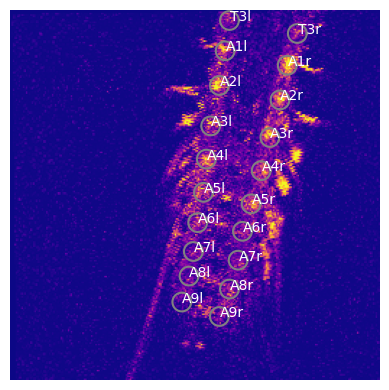

In [73]:
import imageio
from tifffile import imread
import skimage as ski
import skimage.io as skio

import roifile
from roifile import roiread
from roifile import ImagejRoi

import os



image_data = ski.io.imread('Hunch-stabilised.tif')
#image_data = ski.io.imread('head cast.tif')

# image_filtered = ski.filters.gaussian(image_data, sigma=1)
image_filtered = ski.io.imread('Hunch-stabilised.tif')

#image_filtered = ski.io.imread('filtered_gaussian_1um_headcast.tif')
# image_filtered = imread('3d_filtered_gaussian_2um_headcast.tif')

################## ROIS ##################

# Get a list of all .roi files in the RoiSet directory
RoiSet = [f for f in os.listdir('/content/RoiSet') if f.endswith('.roi')]

# Load ROIs file
rois = []
rois_coordinates = []

dict_rois_name_xy = dict()

for roi_file in RoiSet:
  # read ROIs 1 by 1 from RoiSet folder
  roi = roiread('/content/RoiSet/'+roi_file)
  rois.append(roi)
  rois_coordinates.append(roi.coordinates())

  stripped_roi_file = roi_file.replace('.roi', '')

  ### create dictionnary that links name to coordinates
  dict_rois_name_xy[stripped_roi_file] = roi.coordinates()


# plt.imshow(image_data[0])
# plt.axis('off')
# plt.show()

dict_rois_baseline, dict_rois_df, dict_rois_df_f = DFOF_optimized_roi(image_data, dict_rois_name_xy)

roi_names = list(dict_rois_name_xy.keys())


plot_image_overlays(image_filtered[600], rois, roi_names )

In [ ]:
# from dictionaries dict_rois_baseline, dict_rois_df, dict_rois_df_f, each key corresponds to ROI of my image, and the values are baseline, df, df_f, I will plot the trace of each pixels baseline&image_filtered, and df_ff or each value for each roi

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_traces(dict_rois_baseline, dict_rois_df_f, dict_rois_name_xy):
    """Plots the traces of baseline and df/f for each ROI."""
    for roi_name in dict_rois_name_xy:
        baseline = dict_rois_baseline[roi_name]
        dff = dict_rois_df_f[roi_name]

        num_pixels = dff.shape[1]

        plt.figure(figsize=(10, 6))  # Adjust figure size as needed

        for pixel in range(num_pixels):

            plt.plot(baseline[:,pixel])
            #plt.plot(dff[:,pixel])

        plt.xlabel('Time Frame')
        plt.ylabel('Intensity')
        plt.title(f'Traces for ROI {roi_name}')
        plt.legend()
        plt.show()

plot_traces(dict_rois_baseline, dict_rois_df_f, dict_rois_name_xy)
# plot_ridge_plot(dict_rois_baseline, dict_rois_df_f, dict_rois_name_xy)


In [ ]:
#### plot average pixel trace for each ROI
num_rois = len(dict_rois_name_xy)
fig, axes = plt.subplots(num_rois, 1, figsize=(10, 6 * num_rois), sharex=True)

# Loop through ROIs and plot on respective subplots
for i,roi_name in enumerate(dict_rois_name_xy):

    dff = dict_rois_df_f[roi_name]
    avg_pixel_df_f = np.mean(dff, axis=1)  # Calculate average dff across all pixels for this ROI

    axes[i].plot(avg_pixel_df_f)  # Plot the average dff trace
    axes[i].set_ylabel('Intensity')
    axes[i].set_title(f'Average Pixel Trace for ROI {roi_name}')
    axes[i].set_ylim(-1,1)

# Set common x-axis label for the entire figure
plt.xlabel('Time Frame')
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()




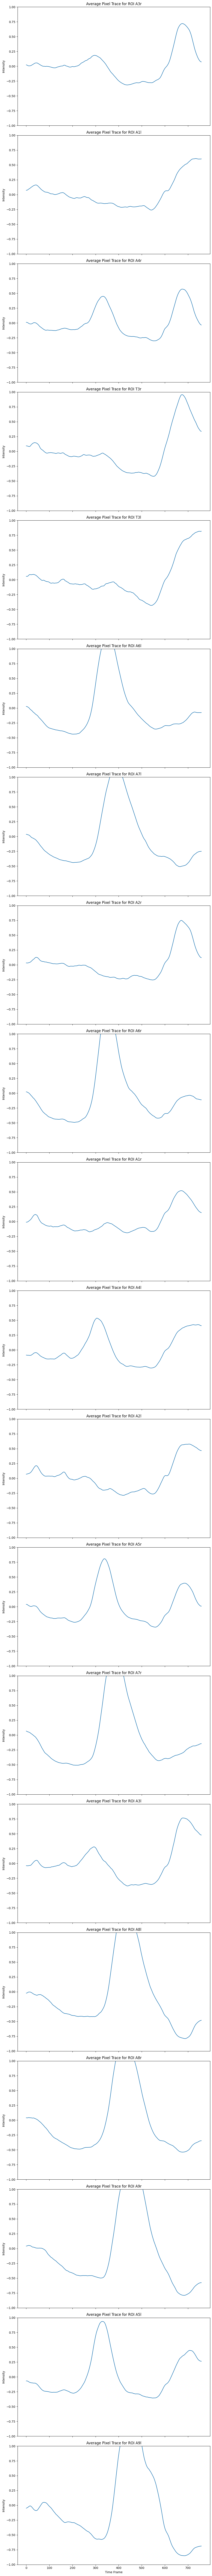

In [77]:
############ smooth the data using Whittaker-Eiler filter
from whittaker_eilers import WhittakerSmoother
print()
whittaker_smoother = WhittakerSmoother(
    lmbda=100, order=1, data_length=(dict_rois_df_f['A6r'].shape[0])
)


num_rois = len(dict_rois_name_xy)
fig, axes = plt.subplots(num_rois, 1, figsize=(10, 6 * num_rois), sharex=True)

# Loop through ROIs and plot on respective subplots
for i,roi_name in enumerate(dict_rois_name_xy):

    dff = dict_rois_df_f[roi_name]
    avg_pixel_df_f = np.mean(dff, axis=1)  # Calculate average dff across all pixels for this ROI

    smoothed_df_f = whittaker_smoother.smooth(avg_pixel_df_f)


    axes[i].plot(smoothed_df_f)  # Plot the average dff trace
    axes[i].set_ylabel('Intensity')
    axes[i].set_title(f'Average Pixel Trace for ROI {roi_name}')
    axes[i].set_ylim(-1,1)

# Set common x-axis label for the entire figure
plt.xlabel('Time Frame')
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

['T3l', 'T3r', 'A1l', 'A1r', 'A2l', 'A2r', 'A3l', 'A3r', 'A4l', 'A4r', 'A5l', 'A5r', 'A6l', 'A6r', 'A7l', 'A7r', 'A8l', 'A8r', 'A9l', 'A9r']
['T3l', 'T3r', 'A1l', 'A1r', 'A2l', 'A2r', 'A3l', 'A3r', 'A4l', 'A4r', 'A5l', 'A5r', 'A6l', 'A6r', 'A7l', 'A7r', 'A8l', 'A8r', 'A9l', 'A9r']


<ipython-input-86-27647349f4aa>:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')  # You might want to adjust the legend to include the zero line


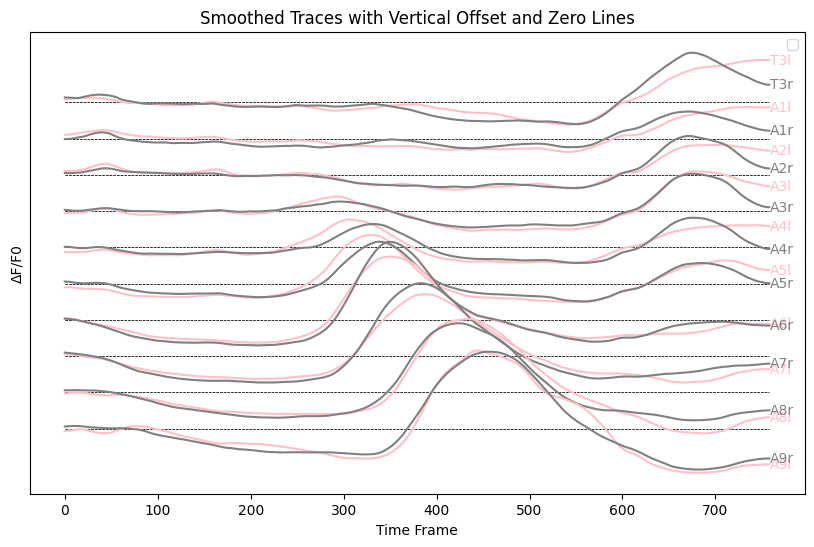

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from whittaker_eilers import WhittakerSmoother

# Initialize the Whittaker smoother
whittaker_smoother = WhittakerSmoother(
    lmbda=100, order=1, data_length=(dict_rois_df_f['A6r'].shape[0])
)

num_rois = len(dict_rois_name_xy)
offset_height = 0.35 # Define vertical spacing between traces

fig, ax = plt.subplots(figsize=(10, 6))

# Custom sorting function to prioritize 'T' ROIs
def sort_roi_names(roi_name):
    if roi_name.startswith('T'):
        return (0, roi_name)  # 'T' ROIs come first
    else:
        return (1, roi_name)  # Other ROIs come after

sorted_rois_name_xy = sorted(dict_rois_name_xy, key=sort_roi_names)

print(sorted_rois_name_xy)

# Loop through ROIs and plot with offsets
for i, roi_name in enumerate(sorted_rois_name_xy):



    if i % 2 == 0:  # Even index (left side ROIs)
        offset = -offset_height * (i )  # Divide by 2 for proper spacing
        color = 'pink'  # Set color to pink for left side
    else:  # Odd index (right side ROIs)
        offset = -offset_height * ((i - 1) )  # Divide by 2 for proper spacing
        color = 'gray'  # Set color to gray for right side

    dff = dict_rois_df_f[roi_name]
    avg_pixel_df_f = np.mean(dff, axis=1)  # Average dF/F for this ROI
    smoothed_df_f = np.array(whittaker_smoother.smooth(avg_pixel_df_f))

    # Plot the smoothed trace with offset
    ax.plot(smoothed_df_f + offset, color=color)

    # Add text label next to the trace
    ax.text(len(smoothed_df_f), smoothed_df_f[-1] + offset, roi_name, color=color,
            ha='left', va='center')

    # Add a zero line for the current offset
    ax.plot(np.zeros_like(smoothed_df_f) + offset, color='black', linestyle='--', linewidth=0.5, alpha=0.8, zorder=1)  # Added alpha and zorder for visibility

ax.set_yticks([])
# Set labels and legend
ax.set_xlabel('Time Frame')
ax.set_ylabel('ΔF/F0')
ax.legend(loc='upper right')  # You might want to adjust the legend to include the zero line
plt.title('Smoothed Traces with Vertical Offset and Zero Lines')
plt.show()

Please enter stimulus start frame: 300
Please enter stimulus duration: 100
['T3l', 'T3r', 'A1l', 'A1r', 'A2l', 'A2r', 'A3l', 'A3r', 'A4l', 'A4r', 'A5l', 'A5r', 'A6l', 'A6r', 'A7l', 'A7r', 'A8l', 'A8r', 'A9l', 'A9r']


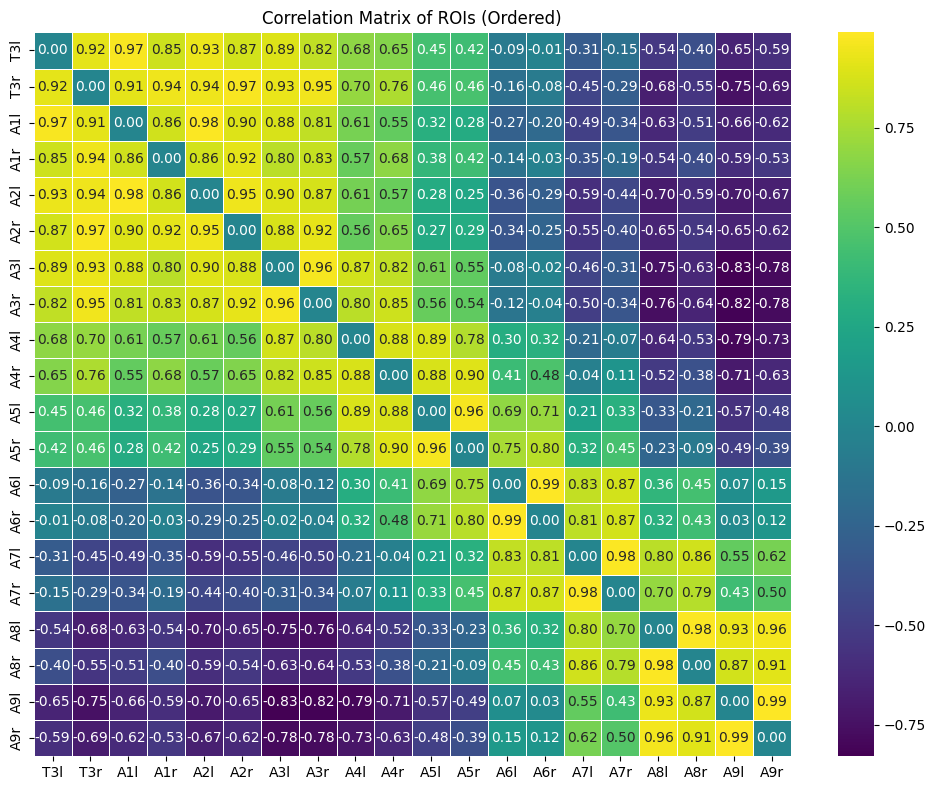

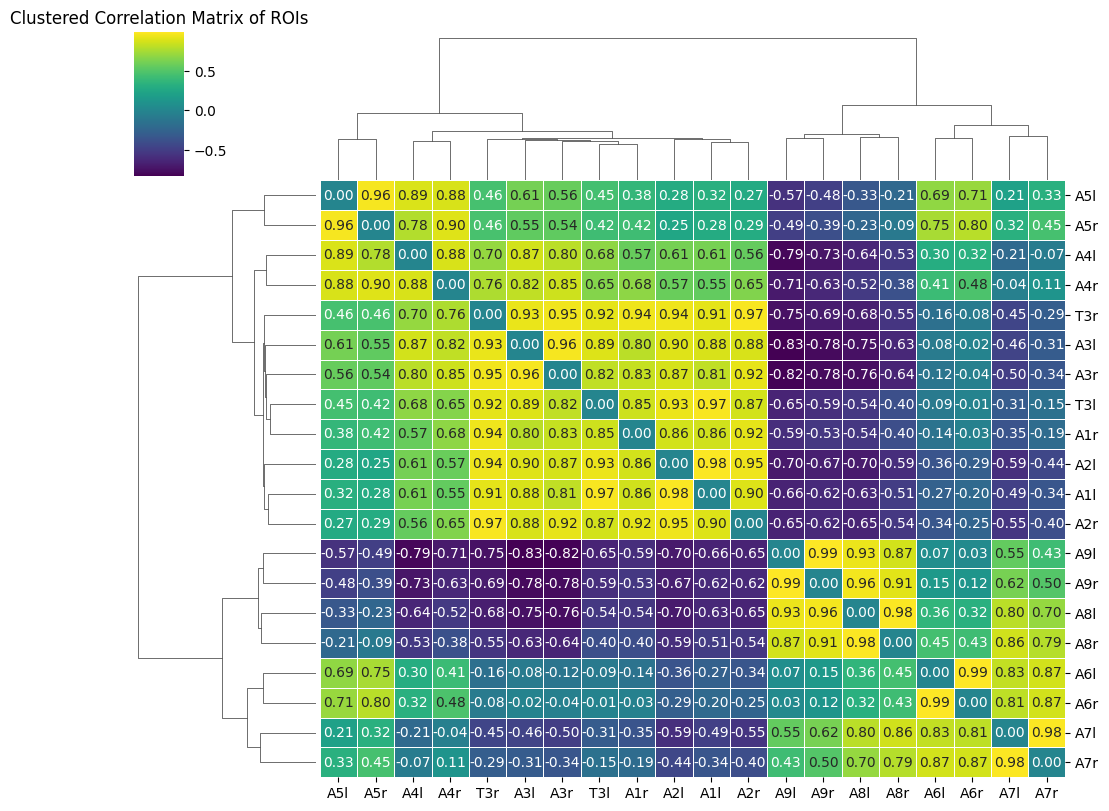

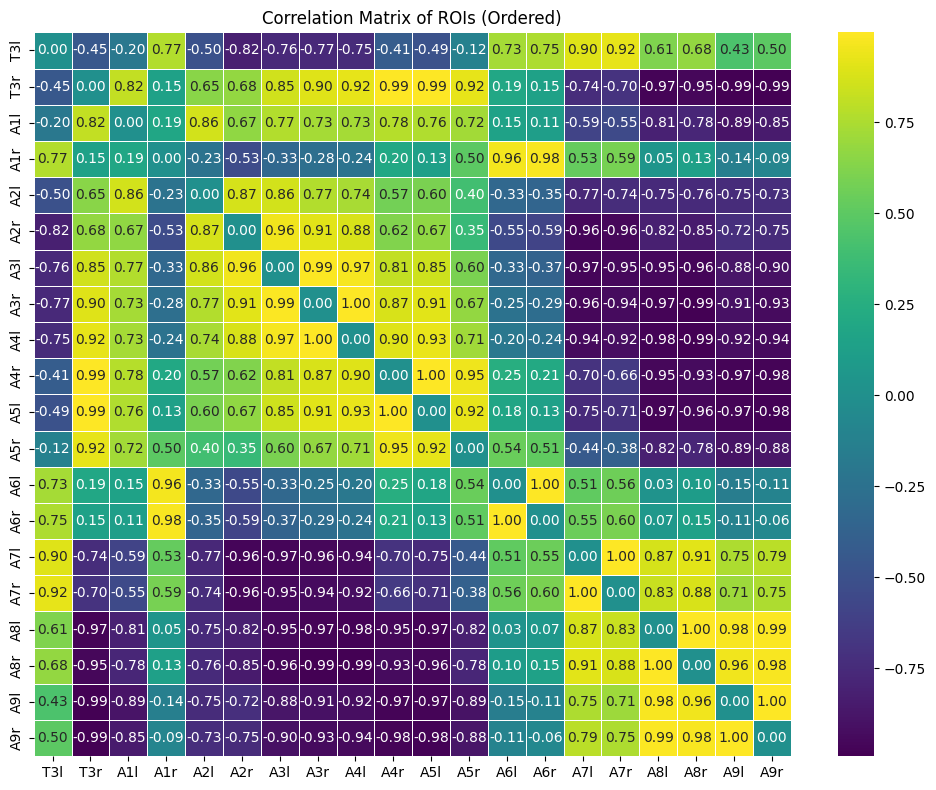

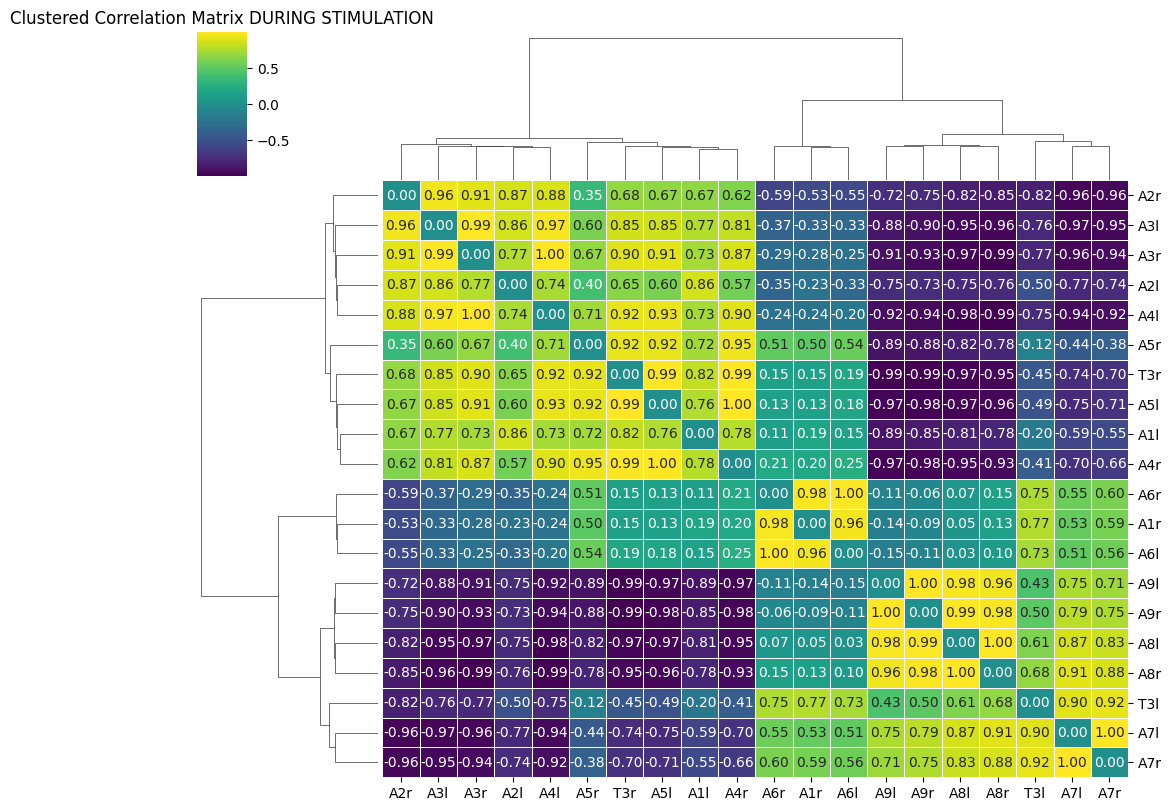

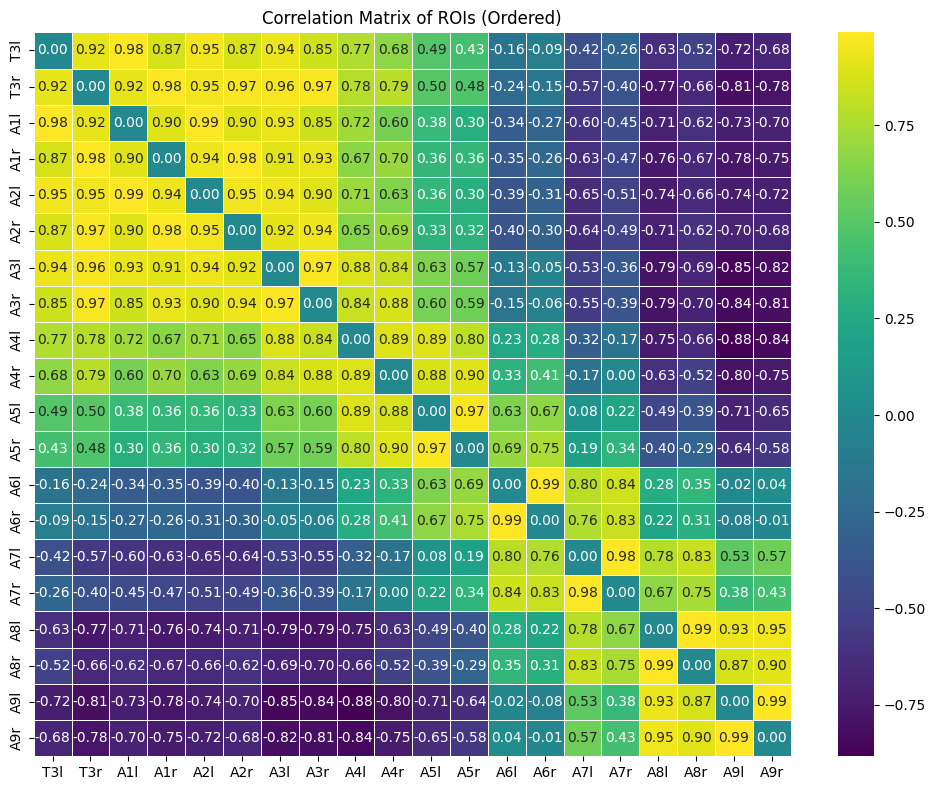

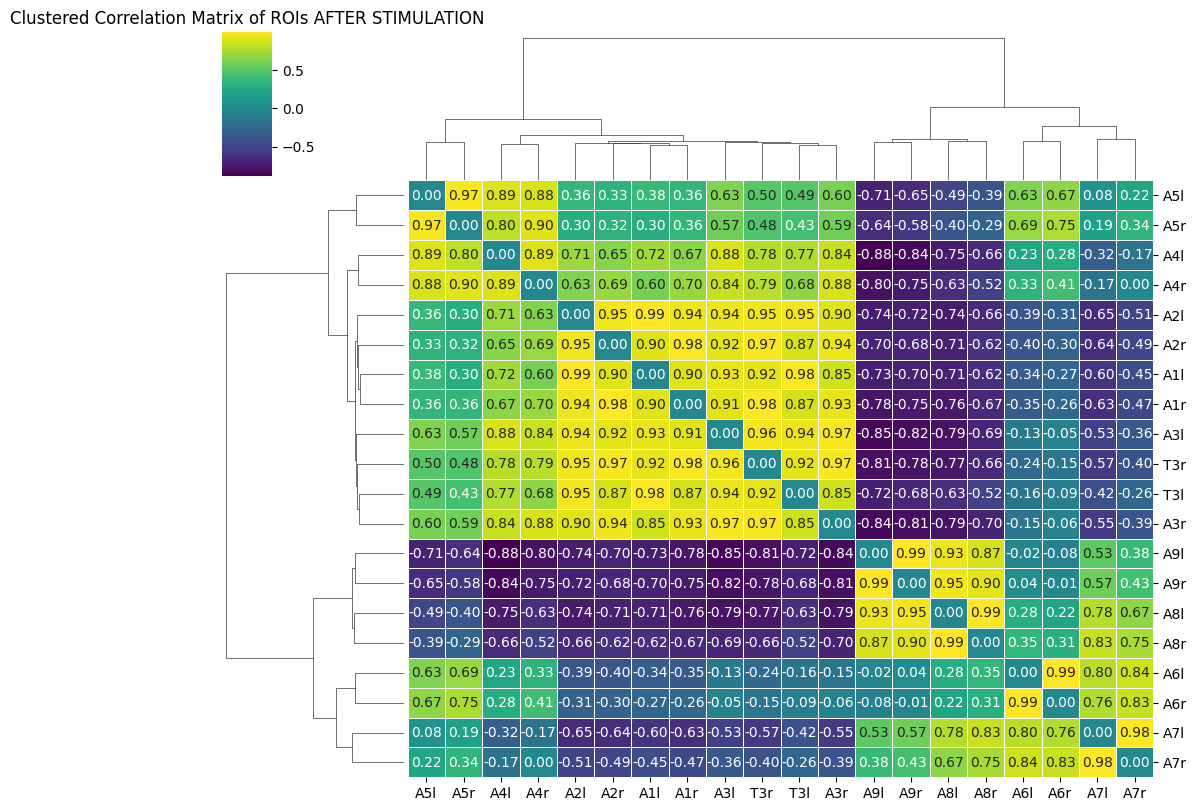

In [90]:
import re
import pandas as pd

stimulus_start = input("Please enter stimulus start frame: ")
stimulus_duration = input("Please enter stimulus duration: ")
stimulus_frame = int(stimulus_start)
stimulus_duration = int(stimulus_duration)

# Custom sorting function to prioritize 'T' ROIs
def sort_roi_names(roi_name):
    if roi_name.startswith('T'):
        return (0, roi_name)  # 'T' ROIs come first
    else:
        return (1, roi_name)  # Other ROIs come after

sorted_roi_names = sorted(dict_rois_name_xy, key=sort_roi_names)

print(sorted_rois_name_xy)

# Create an empty correlation matrix
num_rois = len(sorted_roi_names)
correlation_matrix = np.zeros((num_rois, num_rois))

# Calculate correlations between all pairs of ROIs (using sorted roi_names)

for i in range(num_rois):
    for j in range(i + 1, num_rois):  # Avoid redundant calculations
        roi1_data = dict_smooth_avg_pixel_df_f[sorted_roi_names[i]]
        roi2_data = dict_smooth_avg_pixel_df_f[sorted_roi_names[j]]
        correlation, _ = stats.pearsonr(roi1_data, roi2_data)
        correlation_matrix[i, j] = correlation_matrix[j, i] = correlation

# Create a Pandas DataFrame for the correlation matrix (using sorted roi_names)
df_corr = pd.DataFrame(correlation_matrix, index=sorted_roi_names, columns=sorted_roi_names)

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(df_corr, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of ROIs (Ordered)')
plt.tight_layout()
plt.show()


# Clustered ordering based on correlation
linkage = sns.clustermap(df_corr, method="average", metric="euclidean", row_cluster=True, col_cluster=True, figsize=(10, 8), cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Clustered Correlation Matrix of ROIs')
plt.show()




# Calculate correlations between all pairs of ROIs (using sorted roi_names) DURINF STIMULUS ONLY

for i in range(num_rois):
    for j in range(i + 1, num_rois):  # Avoid redundant calculations
        roi1_data = dict_smooth_avg_pixel_df_f[sorted_roi_names[i]][stimulus_frame:stimulus_frame+stimulus_duration]
        roi2_data = dict_smooth_avg_pixel_df_f[sorted_roi_names[j]][stimulus_frame:stimulus_frame+stimulus_duration]
        correlation, _ = stats.pearsonr(roi1_data, roi2_data)
        correlation_matrix[i, j] = correlation_matrix[j, i] = correlation

# Create a Pandas DataFrame for the correlation matrix (using sorted roi_names)
df_corr = pd.DataFrame(correlation_matrix, index=sorted_roi_names, columns=sorted_roi_names)

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(df_corr, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of ROIs (Ordered)')
plt.tight_layout()
plt.show()


# Clustered ordering based on correlation
linkage = sns.clustermap(df_corr, method="average", metric="euclidean", row_cluster=True, col_cluster=True, figsize=(10, 8), cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Clustered Correlation Matrix DURING STIMULATION')
plt.show()


# Calculate correlations between all pairs of ROIs (using sorted roi_names) AFTER STIMULUS

for i in range(num_rois):
    for j in range(i + 1, num_rois):  # Avoid redundant calculations
        roi1_data = dict_smooth_avg_pixel_df_f[sorted_roi_names[i]][stimulus_frame:-1]
        roi2_data = dict_smooth_avg_pixel_df_f[sorted_roi_names[j]][stimulus_frame:-1]
        correlation, _ = stats.pearsonr(roi1_data, roi2_data)
        correlation_matrix[i, j] = correlation_matrix[j, i] = correlation

# Create a Pandas DataFrame for the correlation matrix (using sorted roi_names)
df_corr = pd.DataFrame(correlation_matrix, index=sorted_roi_names, columns=sorted_roi_names)

# Plot the correlation matrix using Seaborn heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(df_corr, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of ROIs (Ordered)')
plt.tight_layout()
plt.show()


# Clustered ordering based on correlation
linkage = sns.clustermap(df_corr, method="average", metric="euclidean", row_cluster=True, col_cluster=True, figsize=(10, 8), cmap='viridis', annot=True, fmt=".2f", linewidths=.5)
plt.title('Clustered Correlation Matrix of ROIs AFTER STIMULATION')
plt.show()

In [81]:
#### SAVE THE DATA

# store in csv, traces of of each pixel in each ROIs (116 pixels each) along time series (1519 time points) for dF/F and baseline

# csv for each measure , have pixel number --> time series

import csv


with open("Baseline_Values_Headcast_Allpixels_perROIs.csv", "w", newline="") as f:

    header = list(dict_rois_baseline.keys()) # Get the keys of the dictionary as a list
    # make this list 116(number of pixels) times bigger to have header for every value
    repeated_header = []

    for item in header:
      repeats = (dict_rois_baseline[item].shape)[1]

      repeated_header.extend([item] * repeats)

    w = csv.writer(f) # Use csv.writer instead of csv.DictWriter

    w.writerow(repeated_header) # Write the header row with ROI names

    # Since the data is a 3D array, we need to iterate and write each row
    for i in range(dict_rois_baseline[header[0]].shape[0]): # Iterate through rows (time points)
        row_data = [dict_rois_baseline[roi_name][i,:] for roi_name in header] # Extract data for each ROI for this row
        # Flatten the row_data list to write as a single row in the CSV
        flattened_row_data = [item for sublist in row_data for item in sublist]
        w.writerow(flattened_row_data) # Write data for each ROI in this timepoint/row



with open("DF_F0_Values_Headcast_Allpixels_perROIs.csv", "w", newline="") as f:

    header = list(dict_rois_df_f.keys()) # Get the keys of the dictionary as a list
    # make this list 116(number of pixels) times bigger to have header for every value
    repeated_header = []

    for item in header:
      repeats = (dict_rois_df_f[item].shape)[1]

      repeated_header.extend([item] * repeats)

    w = csv.writer(f) # Use csv.writer instead of csv.DictWriter

    w.writerow(repeated_header) # Write the header row with ROI names

    # Since the data is a 3D array, we need to iterate and write each row
    for i in range(dict_rois_df_f[header[0]].shape[0]): # Iterate through rows (time points)
        row_data = [dict_rois_df_f[roi_name][i,:] for roi_name in header] # Extract data for each ROI for this row
        # Flatten the row_data list to write as a single row in the CSV
        flattened_row_data = [item for sublist in row_data for item in sublist]
        w.writerow(flattened_row_data) # Write data for each ROI in this timepoint/row



In [82]:

dict_avg_pixel_df_f = dict()
# Loop through ROIs
for i,roi_name in enumerate(dict_rois_df_f):

    dff = dict_rois_df_f[roi_name]
    dict_avg_pixel_df_f[roi_name] = np.mean(dff, axis=1)

my_dict = dict_avg_pixel_df_f

with open("Average_DF_F0_Values_Headcast_perROIs.csv", "w", newline="") as f:


      header = list(dict_rois_baseline.keys())
      w = csv.writer(f)

      w.writerow(header) # Write the header row with ROI names
      for i in range(dict_avg_pixel_df_f[header[0]].shape[0]): # Iterate through rows (time points)

        row_data = [dict_avg_pixel_df_f[roi_name][i] for roi_name in header] # Extract data for each ROI for this row
        # Flatten the row_data list to write as a single row in the CSV
        w.writerow(row_data) # Write data for each ROI in this timepoint/row



In [83]:
####### STORE SMOOTH TRACE

from whittaker_eilers import WhittakerSmoother

# Initialize the Whittaker smoother
whittaker_smoother = WhittakerSmoother(
    lmbda=100, order=1, data_length=(dict_rois_df_f['A6r'].shape[0])
)



dict_smooth_avg_pixel_df_f = dict()
# Loop through ROIs
for i,roi_name in enumerate(dict_rois_df_f):

    dff = dict_rois_df_f[roi_name]
    avg_pixel_df_f = np.mean(dff, axis=1)
    smoothed_df_f = np.array(whittaker_smoother.smooth(avg_pixel_df_f))

    dict_smooth_avg_pixel_df_f[roi_name] = smoothed_df_f


with open("Smooth_Average_DF_F0_Values_Headcast_perROIs.csv", "w", newline="") as f:


      header = list(dict_rois_baseline.keys())
      w = csv.writer(f)

      w.writerow(header) # Write the header row with ROI names
      for i in range(dict_smooth_avg_pixel_df_f[header[0]].shape[0]): # Iterate through rows (time points)

        row_data = [dict_smooth_avg_pixel_df_f[roi_name][i] for roi_name in header] # Extract data for each ROI for this row
        # Flatten the row_data list to write as a single row in the CSV
        w.writerow(row_data) # Write data for each ROI in this timepoint/row





In [ ]:
##### in txt file
import csv
csv_file = input('Smooth_Average_DF_F0_Values_Headcast_perROIs.csv')
txt_file = input('Smooth_Average_DF_F0_Values_Headcast_perROIs.txt')
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [ ]:
##### STORE IT ALONG COLUMNS INSTEAD
###### not useful

dict_avg_pixel_df_f = {}

# Compute the mean across axis=1 (rows) for each ROI
for roi_name, dff in dict_rois_df_f.items():
    dict_avg_pixel_df_f[roi_name] = np.mean(dff, axis=1)  # Mean along axis 1

# Get ROI names (these will be row headers)
roi_names = list(dict_avg_pixel_df_f.keys())

# Get the number of time points from the first ROI
num_timepoints = len(dict_avg_pixel_df_f[roi_names[0]])

# Open file for writing
with open("ROW_Average_DF_F0_Values_Headcast_perROIs.csv", "w", newline="") as f:
    w = csv.writer(f)

    # Write header (time points: 0, 1, 2, ..., 1518)
    timepoint_labels = [f"t{i}" for i in range(num_timepoints)]
    w.writerow(["ROI"] + timepoint_labels)  # First column is "ROI" names

    # Write each ROI's data as a row
    for roi_name in roi_names:
        row_data = [roi_name] + list(dict_avg_pixel_df_f[roi_name])  # ROI name + its time series
        w.writerow(row_data)
